### Isolation Forest for Anomaly Detection


In [1]:
#importing the modules
import sklearn
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
print('python',sys.version.split()[0])
print('np',np.__version__)
print('pd',pd.__version__)
print('matplotlib',matplotlib.__version__)
print('sklearn',sklearn.__version__)

python 3.9.12
np 1.23.1
pd 1.4.3
matplotlib 3.5.2
sklearn 1.1.1


In [3]:
# creating the target variable
p_fraud = 1/500
p_normal = 1 - p_fraud
N_data = 100_000
arr = np.random.choice([0, 1], size=N_data, p=[p_normal, p_fraud])
N_total = len(arr)
N_fraud = arr.sum()
N_normal = N_total - N_fraud
print(f"N_total  = {N_total:8,d}")
print(f"N_normal = {N_normal:8,d}")
print(f"N_fraud  = {N_fraud:8,d}")
print(f"normal/fraud = {N_normal//N_fraud}")

N_total  =  100,000
N_normal =   99,799
N_fraud  =      201
normal/fraud = 496


In [4]:
df = pd.DataFrame({'target':arr})

In [5]:
# creating the 30 features 
f1_loc = [1,2,0.5,0.7,3,4,5]
f1_scale = [1,2,3,4,5,6,7,8]
weights = [0.001, 0.01, 0.1, 0, 1,2,5,10,20,50, 100]
for i in range(1,31):
    loc = np.random.choice(f1_loc)
    scale = np.random.choice(f1_scale)
    size = len(arr)
    f1 = np.random.normal(loc=loc, scale=scale, size=size)
    wf = np.random.choice(weights)
    wt = np.random.choice(weights)
    df[i] = wf*f1 + wt*arr

In [6]:
# having a look at the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  100000 non-null  int64  
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21      100

In [7]:
# checking if there are any null values
df.isnull().values.any()

False

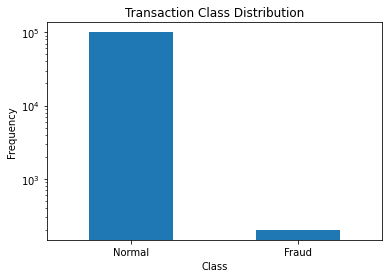

In [8]:
# showing number of normal and fraud transactions 
count_classes = pd.value_counts(df['target'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [9]:
## Get the Fraud and the normal datasets
fraud = df[df['target']==1]
normal = df[df['target']==0]

In [10]:
print(fraud.shape,normal.shape)

(201, 31) (99799, 31)


In [11]:
# Create independent and Dependent Features
columns = df.columns.tolist()

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["target"]]

# Store the variable we are predicting 
target = "target"

# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(100000, 30)
(100000,)


In [12]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 100, 
                                                    stratify = Y)

In [13]:
# Take a look at the train dataset
print("X_train:")
display(X_train)
print("\n","-"*50)
print("y_train:")
display(y_train)

X_train:


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
70508,20.703180,1013.719817,997.028229,0.126064,0.015669,0.0,0.0,-19.061482,354.640468,0.0,...,-0.002801,24.917079,1.119526,204.121690,564.864263,18.974857,0.514683,46.069369,9.016765,0.0
52883,11.341715,-19.414503,-193.960743,-0.252151,0.043763,0.0,0.0,94.226570,-264.851046,0.0,...,0.003419,11.967523,2.870170,454.517591,4.720766,33.438681,1.168888,428.736113,31.813001,0.0
18497,1.059102,505.061866,469.021723,-0.230546,0.045464,0.0,0.0,-187.495420,23.892635,0.0,...,-0.001020,10.697972,2.874878,199.997724,-146.642733,-18.984237,1.105097,139.429794,22.276668,0.0
29311,8.482728,-344.067251,679.760133,-0.256265,0.037688,0.0,0.0,559.605853,-38.209076,0.0,...,-0.001461,13.179990,5.330732,244.120781,331.681127,21.104787,-0.438029,-192.041537,29.642220,0.0
87590,9.014397,-285.873207,879.286163,1.937459,0.016136,0.0,0.0,304.171129,-139.188340,0.0,...,-0.000261,22.433177,4.987495,487.571359,-277.671949,11.054675,-0.535784,233.741444,30.344684,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,-5.810067,-339.169463,-172.609260,-0.745642,0.036827,0.0,0.0,178.000414,669.995955,0.0,...,0.001227,14.133213,4.118940,353.171547,-256.190250,-13.580287,-0.446062,51.664062,34.594581,0.0
95148,9.149585,333.330340,227.167876,-0.216626,0.016321,0.0,0.0,315.404359,474.852076,0.0,...,0.004695,30.091093,4.136902,372.795687,239.947493,9.020384,0.146801,132.819505,18.980434,0.0
59388,11.034802,439.382823,724.017367,-0.254801,0.028052,0.0,0.0,-21.174373,-103.701235,0.0,...,-0.001257,4.645874,3.322881,218.613341,430.428112,-6.355519,-1.868156,77.840659,25.194314,0.0
99630,-2.334197,432.179185,-525.784382,0.138312,0.045090,0.0,0.0,539.937956,-357.386808,0.0,...,0.002866,11.592145,3.557875,251.216337,-114.187731,-61.278098,0.342106,500.032336,22.062493,0.0



 --------------------------------------------------
y_train:


70508    0
52883    0
18497    0
29311    0
87590    0
        ..
1740     0
95148    0
59388    0
99630    0
66528    0
Name: target, Length: 70000, dtype: int64

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 30)
(70000,)
(30000, 30)
(30000,)


In [15]:
# training:
ss = y_train.value_counts()
print(f"proportion of fraud in train data: {ss[1]/len(y_train):7.4f}")

#tresting:
ss = y_test.value_counts()
print(f"proportion of fraud in test  data: {ss[1]/len(y_test):7.4f}")

proportion of fraud in train data:  0.0020
proportion of fraud in test  data:  0.0020


In [16]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = df[df['target']==1]

Valid = df[df['target']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [17]:
##Define the outlier detection methods

model = IsolationForest(n_estimators=100, 
                        max_samples=len(X_train),
                        contamination=outlier_fraction,
                        random_state=state, 
                        verbose=0)

In [18]:
# train the model and do prediction
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [19]:
# calculate quality metrics of the model
# accuracyReshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

Accuracy Score :
1.0
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29940
           1       1.00      1.00      1.00        60

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [20]:
#Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

Confusion matrix:
[[29940     0]
 [    0    60]]
